# UNSUPERVISED LEARNING 

In [198]:
pip install --upgrade scikit-learn threadpoolctl


Note: you may need to restart the kernel to use updated packages.


In [209]:
pip install pandas scikit-learn matplotlib seaborn


In [210]:
pip install sqlalchemy pyodbc


Note: you may need to restart the kernel to use updated packages.


# Import Libraries



In [245]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sqlalchemy import create_engine
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns
from threadpoolctl import threadpool_limits
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import seaborn as sns


# Connect to Database

In [246]:


# Connexion à la base de données
def connect_engine():
    connection_string = quote_plus(
        "DRIVER={SQL Server};"
        "SERVER=LAPTOP-PTEGCH09\\SQLSERVER122;"
        "DATABASE=DW_SAP_Co2;"
        "Trusted_Connection=yes;"
    )
    return create_engine(f"mssql+pyodbc:///?odbc_connect={connection_string}")

# Load Dim_Supplier Table

In [247]:

# Charger la table Dim_Supplier
def load_suppliers():
    engine = connect_engine()
    query = "SELECT * FROM Dim_Supplier"
    return pd.read_sql(query, engine)

# Load Dim_Transport_Type Table

In [248]:
def load_transport():
    engine = connect_engine()
    query = "SELECT * FROM Dim_Transport_Type"
    df = pd.read_sql(query, engine)
    
    # Display table info
    print("Dim_Transport_Type Table Info:")
    print(df.info())  # Information about columns and data types
    print("\nDim_Transport_Type Table Sample Data:")
    print(df.head())  # Display a sample of the first 5 rows
    
    return df


# Load Fact_Co2_Emissions Table

In [249]:
# 1. Remove duplicates in the Fact_Co2_Emissions table
def load_co2_emissions():
    engine = connect_engine()
    query = "SELECT DISTINCT * FROM Fact_Co2_Emissions"  # Use DISTINCT to remove duplicates
    return pd.read_sql(query, engine)


# Load and Merge Tables

In [250]:
# 2. Remove duplicates from merged data
def load_and_merge():
    df_suppliers = load_suppliers()
    df_transport = load_transport()
    df_co2 = load_co2_emissions()
    
    # Ensure no duplicate Fk_Supplier in the fact table
    df_co2 = df_co2.drop_duplicates(subset='Fk_Supplier')
    
    # Merge the tables as usual
    df = df_co2.merge(df_suppliers[['Pk_Supplier', 'Environmental_Certifications', 
                                     'Sustainability_Program', 'Fk_Type_Transport']], 
                      left_on='Fk_Supplier', right_on='Pk_Supplier', how='left')
    
    df = df.merge(df_transport[['Pk_transport', 'Transport_Type']], 
                  left_on='Fk_Type_Transport', right_on='Pk_transport', how='left')
    
    df = df[['Fk_Supplier', 'Renewable_Energy_Percentage', 'Environmental_Certifications', 
             'Sustainability_Program', 'Transport_Type']]
    
    # Fill missing values
    df.fillna({
        'Environmental_Certifications': 'None',
        'Sustainability_Program': 'None',
        'Transport_Type': 'Unknown',
        'Renewable_Energy_Percentage': 0
    }, inplace=True)
    
    return df

# Define the preprocess_data Function

In [251]:
# Prétraitement des données
def preprocess_data(df):
    # Convertir les variables catégorielles en numériques
    label_encoder = LabelEncoder()
    df['Environmental_Certifications'] = label_encoder.fit_transform(df['Environmental_Certifications'])
    df['Sustainability_Program'] = label_encoder.fit_transform(df['Sustainability_Program'])
    df['Transport_Type'] = label_encoder.fit_transform(df['Transport_Type'])
    
    # Normaliser les données
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['Renewable_Energy_Percentage', 'Environmental_Certifications', 
                                         'Sustainability_Program', 'Transport_Type']])
    
    return df_scaled

# Charger, fusionner et prétraiter les données
df_merged = load_and_merge()
df_preprocessed = preprocess_data(df_merged)

# Affichage du DataFrame prétraité
print(df_preprocessed)


Dim_Transport_Type Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Pk_transport    6 non-null      int64 
 1   TransportCode   6 non-null      object
 2   Transport_Type  6 non-null      object
dtypes: int64(1), object(2)
memory usage: 276.0+ bytes
None

Dim_Transport_Type Table Sample Data:
   Pk_transport TransportCode Transport_Type
0             1         TT001        Unknown
1             2         TT002    Ferroviaire
2             3         TT003     Multimodal
3             4         TT004         Aérien
4             5         TT005       Maritime
[[-1.17344794 -1.41421356 -1.03774904  0.02549892]
 [-1.23660952 -0.14142136  0.96362411  0.71396984]
 [-0.20748758  1.13137085 -1.03774904 -0.66297199]
 [-0.60178433 -0.14142136  0.96362411  1.40244075]
 [-0.68909469 -0.14142136 -1.03774904 -0.66297199]
 [ 0.97610558 -0.14142136

# SVM

# Support Vector Machines (SVM) Overview
#Support Vector Machines (SVM) is a supervised machine learning algorithm used for both classification and regression tasks.
#It works by finding the optimal hyperplane that best separates data points of different classes in a high-dimensional space.

1-Kernel Trick Flexibility
2-Robust Against Overfitting
3-Performs well even when the number of features exceeds the number of samples

In [252]:

# 1. Connection to Database
def connect_engine():
    connection_string = quote_plus(
        "DRIVER={SQL Server};"
        "SERVER=LAPTOP-PTEGCH09\\SQLSERVER122;"
        "DATABASE=DW_SAP_Co2;"
        "Trusted_Connection=yes;"
    )
    return create_engine(f"mssql+pyodbc:///?odbc_connect={connection_string}")

# 2. Load Tables from Database
def load_suppliers():
    engine = connect_engine()
    query = "SELECT * FROM Dim_Supplier"
    return pd.read_sql(query, engine)

def load_transport():
    engine = connect_engine()
    query = "SELECT * FROM Dim_Transport_Type"
    return pd.read_sql(query, engine)

# 3. Load and preprocess Fact_Co2_Emissions
def load_co2_emissions():
    engine = connect_engine()
    query = "SELECT DISTINCT Fk_Supplier, Renewable_Energy_Percentage FROM Fact_Co2_Emissions"
    return pd.read_sql(query, engine)

# 4. Load, Merge, and Preprocess Data
def load_and_merge():
    df_suppliers = load_suppliers()
    df_transport = load_transport()
    df_co2 = load_co2_emissions()
    
    # Merge the Fact_Co2_Emissions table with Supplier table based on Fk_Supplier
    df = df_co2.merge(df_suppliers[['Pk_Supplier', 'Environmental_Certifications', 
                                     'Sustainability_Program', 'Fk_Type_Transport']], 
                      left_on='Fk_Supplier', right_on='Pk_Supplier', how='left')
    
    # Merge with transport table
    df = df.merge(df_transport[['Pk_transport', 'Transport_Type']], 
                  left_on='Fk_Type_Transport', right_on='Pk_transport', how='left')
    
    # Drop rows where any of the merged columns have NaN values (i.e., non-matching Fk_Supplier)
    df = df.dropna(subset=['Environmental_Certifications', 'Sustainability_Program', 'Transport_Type'])
    
    # Select only necessary columns
    df = df[['Pk_Supplier', 'Renewable_Energy_Percentage', 'Environmental_Certifications', 
             'Sustainability_Program', 'Transport_Type']]  # Use Pk_Supplier instead of Fk_Supplier
    
    # Handle 'acune' or similar values and fill missing values
    df['Environmental_Certifications'] = df['Environmental_Certifications'].replace({'acune': 'None'})
    
    # Fill missing values
    df.fillna({
        'Environmental_Certifications': 'None',
        'Sustainability_Program': 'None',
        'Transport_Type': 'Unknown',
        'Renewable_Energy_Percentage': 0
    }, inplace=True)
    
    return df

# 5. Data Preprocessing
def preprocess_data(df):
    label_encoder = LabelEncoder()
    df['Environmental_Certifications'] = label_encoder.fit_transform(df['Environmental_Certifications'])
    df['Sustainability_Program'] = label_encoder.fit_transform(df['Sustainability_Program'])
    df['Transport_Type'] = label_encoder.fit_transform(df['Transport_Type'])
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[['Renewable_Energy_Percentage', 'Environmental_Certifications', 
                                         'Sustainability_Program', 'Transport_Type']])
    
    return df_scaled

# 6. Detect Outliers Using One-Class SVM
def detect_outliers(df_scaled):
    model = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')  # nu controls the number of expected outliers
    outliers = model.fit_predict(df_scaled)
    return outliers

# 7. Load, Merge, and Preprocess Data
df_merged = load_and_merge()
df_preprocessed = preprocess_data(df_merged)

# 8. Detect Outliers
outliers = detect_outliers(df_preprocessed)
df_merged['Outlier'] = outliers

# 9. Mark Sustainability Status
df_merged['Sustainability_Status'] = df_merged['Outlier'].apply(lambda x: 'More Sustainable' if x == 1 else 'Less Sustainable')

# 10. Summary of the Data
# Count the number of clusters and suppliers in each category
sustainability_status_count = df_merged['Sustainability_Status'].value_counts()
print(f"Number of suppliers in each category:\n{sustainability_status_count}")

# 11. Display the Most and Least Sustainable Suppliers
more_sustainable_suppliers = df_merged[df_merged['Sustainability_Status'] == 'More Sustainable']
less_sustainable_suppliers = df_merged[df_merged['Sustainability_Status'] == 'Less Sustainable']

# Show the details for the most sustainable suppliers
print(f"Most Sustainable Suppliers:\n{more_sustainable_suppliers[['Pk_Supplier', 'Sustainability_Status']]}")

# Show the details for the least sustainable suppliers
print(f"Less Sustainable Suppliers:\n{less_sustainable_suppliers[['Pk_Supplier', 'Sustainability_Status']]}")

# 12. Average Renewable Energy Percentage for Less Sustainable Suppliers
average_renewable_energy = less_sustainable_suppliers['Renewable_Energy_Percentage'].mean()
print(f"Average Renewable Energy Percentage for Less Sustainable Suppliers: {average_renewable_energy}")

# 13. Environmental Certifications Count for Less Sustainable Suppliers
env_certifications_count = less_sustainable_suppliers['Environmental_Certifications'].value_counts()
print(f"Environmental Certifications Count:\n{env_certifications_count}")

# 14. Sustainability Program Participation Count
sustainability_program_count = less_sustainable_suppliers['Sustainability_Program'].value_counts()
print(f"Sustainability Program Participation Count:\n{sustainability_program_count}")

# 15. Transport Type Count
transport_type_count = less_sustainable_suppliers['Transport_Type'].value_counts()
print(f"Transport Type Count:\n{transport_type_count}")
from sklearn.metrics import mean_squared_error

# Calculer la "valeur prédite" comme la moyenne du pourcentage d'énergie renouvelable de chaque groupe
df_merged['Predicted_RE'] = df_merged.groupby('Sustainability_Status')['Renewable_Energy_Percentage'].transform('mean')

# Calculer le MSE
mse = mean_squared_error(df_merged['Renewable_Energy_Percentage'], df_merged['Predicted_RE'])
print(f"\nMean Squared Error (MSE) of Sustainability Status grouping: {mse:.4f}")



Number of suppliers in each category:
More Sustainable    22
Less Sustainable     5
Name: Sustainability_Status, dtype: int64
Most Sustainable Suppliers:
    Pk_Supplier Sustainability_Status
0             3      More Sustainable
1            47      More Sustainable
2            64      More Sustainable
4            27      More Sustainable
5            69      More Sustainable
6            74      More Sustainable
8             7      More Sustainable
9            10      More Sustainable
10           38      More Sustainable
11           77      More Sustainable
13           12      More Sustainable
14           79      More Sustainable
15           13      More Sustainable
16           83      More Sustainable
17           63      More Sustainable
18           37      More Sustainable
19           52      More Sustainable
20           21      More Sustainable
21           70      More Sustainable
22           32      More Sustainable
23           28      More Sustainable
24        

# KMEANS

KMeans failed, using AgglomerativeClustering as fallback. Error: 'NoneType' object has no attribute 'split'


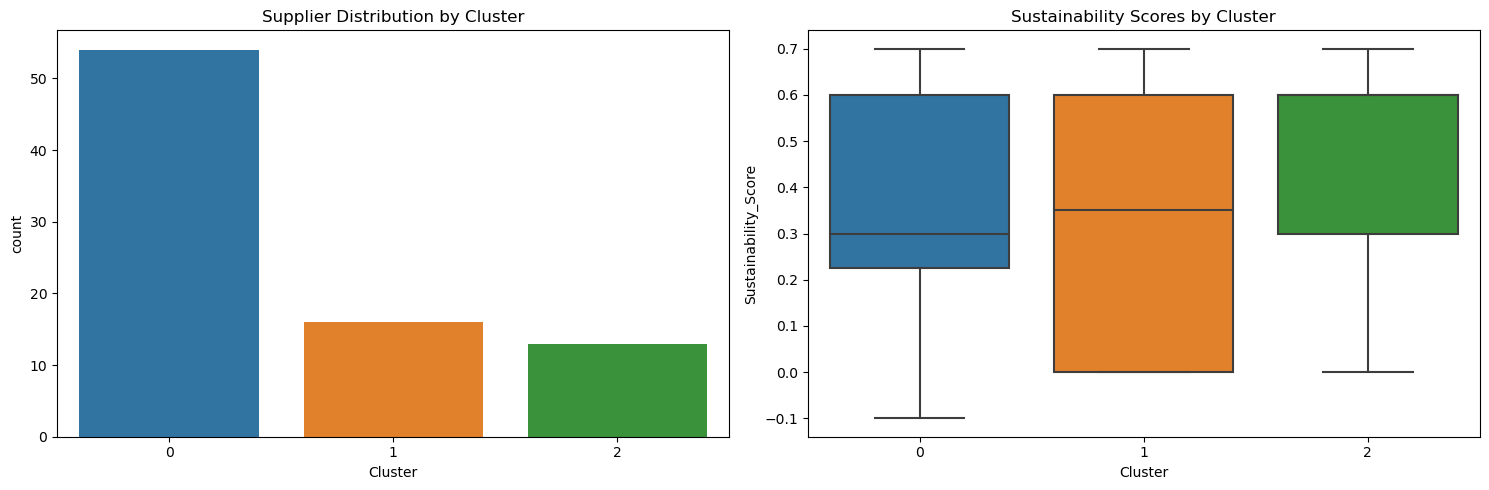


Cluster Characteristics:
         Has_Bio_Cert  Has_ISO_Cert  In_Sustainability_Program  \
Cluster                                                          
0                0.37          0.33                       0.57   
1                0.31          0.38                       0.38   
2                0.23          0.31                       0.85   

         Transport_Rail  Transport_Multimodal  Transport_Air  \
Cluster                                                        
0                   0.0                   0.0           0.11   
1                   1.0                   0.0           0.00   
2                   0.0                   1.0           0.00   

         Transport_Maritime  Transport_Truck  Sustainability_Score  
Cluster                                                             
0                      0.28             0.17                  0.37  
1                      0.00             0.00                  0.35  
2                      0.00             0.00  

In [256]:
def analyze_sustainable_suppliers(output_csv=True, csv_filename='supplier_clusters.csv'):
    # Load and merge data
    df_suppliers = load_suppliers()
    df_transport = load_transport()
    df = pd.merge(df_suppliers, df_transport, 
                 left_on='Fk_Type_Transport', 
                 right_on='Pk_transport', how='left')
    
    # Feature engineering - create binary features
    df['Has_Bio_Cert'] = (df['Environmental_Certifications'] == 'Agriculture Biologique').astype(int)
    df['Has_ISO_Cert'] = (df['Environmental_Certifications'] == 'ISO 14001').astype(int)
    df['In_Sustainability_Program'] = (df['Sustainability_Program'] == 'Oui').astype(int)
    df['Transport_Rail'] = (df['Transport_Type'] == 'Ferroviaire').astype(int)
    df['Transport_Multimodal'] = (df['Transport_Type'] == 'Multimodal').astype(int)
    df['Transport_Air'] = (df['Transport_Type'] == 'Aérien').astype(int)
    df['Transport_Maritime'] = (df['Transport_Type'] == 'Maritime').astype(int)
    df['Transport_Truck'] = (df['Transport_Type'] == 'Camionnage').astype(int)
    
    # Prepare features for clustering
    feature_columns = [
        'Has_Bio_Cert', 'Has_ISO_Cert', 'In_Sustainability_Program',
        'Transport_Rail', 'Transport_Multimodal', 'Transport_Air',
        'Transport_Maritime', 'Transport_Truck'
    ]
    features = df[feature_columns]
    
    # Standardize data
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Set default cluster number
    best_k = 3
    
    try:
        # Attempt KMeans with threadpool limits
        with threadpool_limits(limits=1, user_api='blas'):
            # Calculate WCSS for elbow method
            wcss = []
            possible_k = range(1, 6)
            for k in possible_k:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(features_scaled)
                wcss.append(kmeans.inertia_)
            
            # Plot elbow method
            plt.figure(figsize=(10, 5))
            plt.plot(possible_k, wcss, 'bo-')
            plt.xlabel('Number of clusters')
            plt.ylabel('WCSS')
            plt.title('Elbow Method')
            plt.show()
            
            # Calculate silhouette scores
            silhouette_scores = []
            for k in range(2, 6):
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                preds = kmeans.fit_predict(features_scaled)
                score = silhouette_score(features_scaled, preds)
                silhouette_scores.append(score)
            
            # Determine best k (max silhouette score)
            best_k = np.argmax(silhouette_scores) + 2  # +2 because we started from k=2
            
            # Final clustering
            kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(features_scaled)
            
    except Exception as e:
        print(f"KMeans failed, using AgglomerativeClustering as fallback. Error: {str(e)}")
        # Fallback to hierarchical clustering
        agg = AgglomerativeClustering(n_clusters=best_k)
        clusters = agg.fit_predict(features_scaled)
    
    # Add clusters to data
    df['Cluster'] = clusters
    
    # Calculate sustainability score
    df['Sustainability_Score'] = (
        df['Has_Bio_Cert'] * 0.4 + 
        df['Has_ISO_Cert'] * 0.3 + 
        df['In_Sustainability_Program'] * 0.3 -
        df['Transport_Air'] * 0.2 -
        df['Transport_Maritime'] * 0.1
    )
    
    # Add cluster interpretation
    df['Cluster_Label'] = df['Cluster'].apply(lambda x: f"Cluster_{x+1}")
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Cluster distribution
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='Cluster')
    plt.title('Supplier Distribution by Cluster')
    
    # Sustainability scores
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='Cluster', y='Sustainability_Score')
    plt.title('Sustainability Scores by Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Show cluster characteristics
    cluster_stats = df.groupby('Cluster').agg({
        'Has_Bio_Cert': 'mean',
        'Has_ISO_Cert': 'mean',
        'In_Sustainability_Program': 'mean',
        'Transport_Rail': 'mean',
        'Transport_Multimodal': 'mean',
        'Transport_Air': 'mean',
        'Transport_Maritime': 'mean',
        'Transport_Truck': 'mean',
        'Sustainability_Score': 'mean'
    }).round(2)
    
    print("\nCluster Characteristics:")
    print(cluster_stats)
    
    # Show top sustainable suppliers
    best_cluster = cluster_stats['Sustainability_Score'].idxmax()
    top_suppliers = df[df['Cluster'] == best_cluster].sort_values(
        'Sustainability_Score', ascending=False).head(10)
    
    print("\nTop 10 Most Sustainable Suppliers:")
    print(top_suppliers[['Supplier_Name', 'Transport_Type', 
                        'Environmental_Certifications', 
                        'Sustainability_Program', 
                        'Sustainability_Score', 'Cluster_Label']].to_string(index=False))
    
    # Calculate MSE
    df['Predicted_Score'] = df.groupby('Cluster')['Sustainability_Score'].transform('mean')
    mse = mean_squared_error(df['Sustainability_Score'], df['Predicted_Score'])
    print(f"\nMean Squared Error (MSE) of clustering predictions: {mse:.4f}")

    # Export to CSV if requested
    if output_csv:
        # Create list of columns that actually exist in the DataFrame
        available_cols = [col for col in ['Supplier_Name', 'Transport_Type', 'Environmental_Certifications',
                                        'Sustainability_Program', 'Cluster', 'Cluster_Label', 'Sustainability_Score'] 
                         if col in df.columns]
        
        # Ensure we have some columns to export
        if not available_cols:
            print("Warning: No valid columns found for CSV export")
        else:
            df[available_cols].to_csv(csv_filename, index=False)
            print(f"\nResults saved to {csv_filename}")
    
    return df

if __name__ == "__main__":
    df_results = analyze_sustainable_suppliers(output_csv=True)

# Agglomerative

#Agglomerative clustering is a hierarchical clustering method that 
#builds a tree-like structure (dendrogram) by merging similar data poin
#ts step-by-step. Unlike K-Means, it doesn’t require specifying the number of 
#clusters upfront and works well for small to medium-sized datasets where relationships between data points are important.

1- Handles Non-Globular Clusters Better Than K-Means


2- No Need to Predefine Clusters (K)


Mean Squared Error (Within-Cluster Variance): 1.4604
Silhouette Score: 0.2454
Davies-Bouldin Index: 1.1515


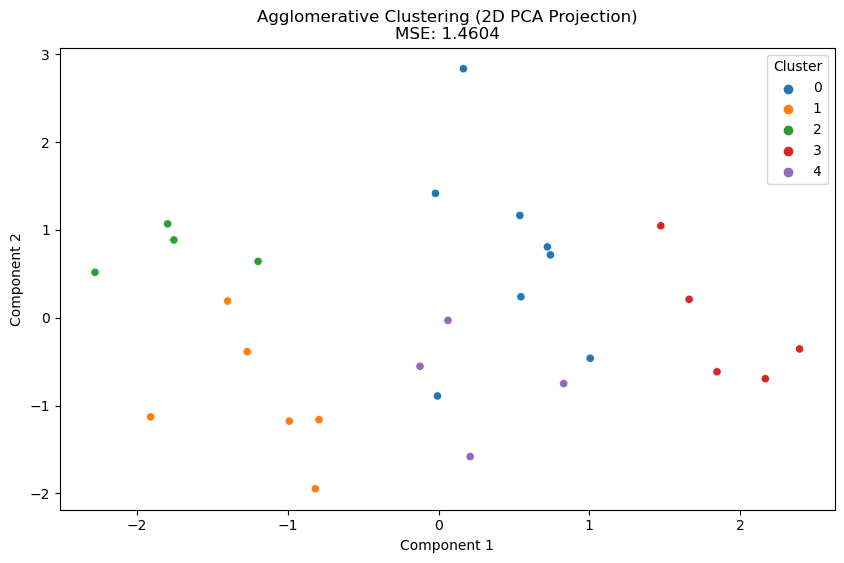

,Cluster,Avg. Renewable Energy %,Most Frequent Transport_Type,Most Frequent Certification
0,0,49.13%,2,1
1,1,17.45%,5,0
2,2,80.29%,3,0
3,3,28.38%,2,2
4,4,26.4%,1,2


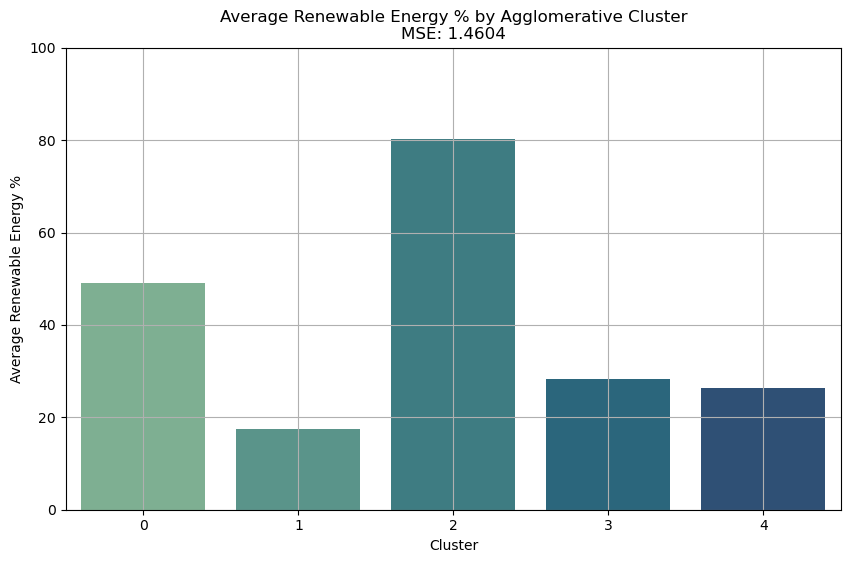

In [242]:


# Step 1: Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')  # You can change n_clusters
agglo_clusters = agglo.fit_predict(df_preprocessed)

# Step 2: Add the results to your dataframe
df_merged['Agglo_Cluster'] = agglo_clusters

# Step 3: Calculate MSE (within-cluster variance)
def calculate_cluster_mse(data, labels):
    cluster_mse = 0
    for cluster in np.unique(labels):
        cluster_points = data[labels == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_mse += ((cluster_points - cluster_center) ** 2).sum()
    return cluster_mse / len(data)

mse_value = calculate_cluster_mse(df_preprocessed, agglo_clusters)
print(f"\nMean Squared Error (Within-Cluster Variance): {mse_value:.4f}")

# Compute Silhouette Score
silhouette_avg = silhouette_score(df_preprocessed, agglo_clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(df_preprocessed, agglo_clusters)
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Step 4: Analyze cluster metrics
categorical_columns = ['Transport_Type', 'Environmental_Certifications']

# Compute mean of numeric column
cluster_means = df_merged.groupby('Agglo_Cluster')['Renewable_Energy_Percentage'].mean().round(2)

# Compute mode of categorical columns
cluster_modes = df_merged.groupby('Agglo_Cluster')[categorical_columns].agg(lambda x: x.mode()[0])

# Combine into summary
agglo_summary = pd.concat([cluster_means, cluster_modes], axis=1).reset_index()

# Format Renewable Energy %
agglo_summary['Avg. Renewable Energy %'] = agglo_summary['Renewable_Energy_Percentage'].astype(str) + '%'

# Step 5: Visualize clustering using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_preprocessed)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_merged['Agglo_Cluster'], palette='tab10')
plt.title('Agglomerative Clustering (2D PCA Projection)\nMSE: {:.4f}'.format(mse_value))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.show()

# Rename for clarity
agglo_summary = agglo_summary.rename(columns={
    'Agglo_Cluster': 'Cluster',
    'Transport_Type': 'Most Frequent Transport_Type',
    'Environmental_Certifications': 'Most Frequent Certification'
})

# Select columns in desired order
agglo_summary = agglo_summary[['Cluster', 'Avg. Renewable Energy %', 'Most Frequent Transport_Type', 'Most Frequent Certification']]

# Display summary table in notebook
display(agglo_summary)

# Optional: Visualization
agglo_summary['Avg. Renewable Energy % (float)'] = agglo_summary['Avg. Renewable Energy %'].str.replace('%', '').astype(float)

plt.figure(figsize=(10, 6))
sns.barplot(data=agglo_summary, x='Cluster', y='Avg. Renewable Energy % (float)', palette='crest')
plt.title('Average Renewable Energy % by Agglomerative Cluster\nMSE: {:.4f}'.format(mse_value))
plt.xlabel('Cluster')
plt.ylabel('Average Renewable Energy %')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

# - Comparison between 3 UNSUPERVISED LEARNING algorithms



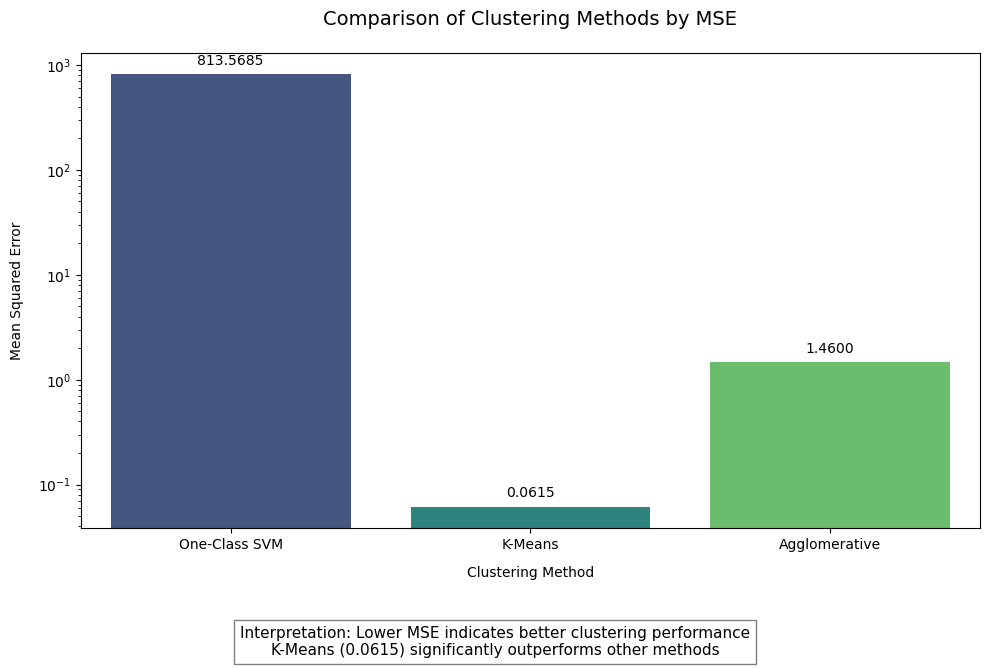


Numerical MSE Comparison:
Clustering Method      MSE
    One-Class SVM 813.5685
          K-Means   0.0615
    Agglomerative   1.4600


In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# MSE results from each method
methods = ['One-Class SVM', 'K-Means', 'Agglomerative']
mse_scores = [813.5685, 0.0615, 1.460]  # Your actual MSE values

# Create DataFrame
mse_comparison = pd.DataFrame({
    'Clustering Method': methods,
    'MSE': mse_scores
})

# Plot settings
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Clustering Method', y='MSE', data=mse_comparison, palette='viridis')

# Customize plot
plt.title('Comparison of Clustering Methods by MSE', pad=20, fontsize=14)
plt.xlabel('Clustering Method', labelpad=10)
plt.ylabel('Mean Squared Error', labelpad=10)
plt.yscale('log')  # Log scale due to large value differences

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

# Add interpretation text
plt.figtext(0.5, -0.1, 
            "Interpretation: Lower MSE indicates better clustering performance\n"
            "K-Means (0.0615) significantly outperforms other methods", 
            ha="center", fontsize=11, bbox={"facecolor":"white", "alpha":0.5})

plt.tight_layout()
plt.show()

# Display numerical comparison
print("\nNumerical MSE Comparison:")
print(mse_comparison.to_string(index=False))

# Conclusion

For general clustering, K-Means is the best choice (lowest MSE, fast, scalable). Use Agglomerative when you need hierarchical relationships or don’t know the number of clusters. One-Class SVM is only suitable for anomaly detection, not standard clustering.

Best pick:

✅ K-Means → Most efficient & accurate

🌳 Agglomerative → Best for hierarchies

🚨 One-Class SVM → Only for outliers